In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from math import factorial

def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

GPU_ID = 0

if torch.cuda.is_available():
     torch.cuda.set_device(GPU_ID) # Select GPU
     print(torch.cuda.device_count(), "GPU(s) available:")
     for i in range(torch.cuda.device_count()):
         print(torch.cuda.get_device_name(i))
else:
     print("No GPUs available.")

device_name = "cuda" + ":" + str(GPU_ID)
device = torch.device(device_name if torch.cuda.is_available() else "cpu")

No GPUs available.


/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Gaussian Beams

The simplest case of a Gaussian beam corresponds to either the Laguerre-Gauss mode with indices $ p = 0 $ and $ l = 0 $, or the Hermite-Gauss mode with indices $ m = 0 $ and $ n = 0 $. The electric field distribution in cylindrical coordinates $ (r, z) $ is given by:

$$
E(r, z) = E_0 \frac{w_0}{w(z)} \exp\left(-\frac{r^2}{w(z)^2}\right) \exp\left(-i \frac{kr^2z}{2(z^2 + z_R^2)}\right) \exp(-i\psi(z))
$$

and in Cartesian coordinates $ (x, y, z) $ by:

$$
E(x, y, z) = E_0 \frac{w_0}{w(z)} \exp\left(-\frac{x^2 + y^2}{w(z)^2}\right) \exp\left(-i \frac{k(x^2 + y^2)z}{2(z^2 + z_R^2)}\right) \exp(-i\psi(z))
$$

where:

- $ E_0 $ is the amplitude of the electric field at the beam waist.
- $ w_0 $ is the waist radius of the beam.
- $ w(z) = w_0 \sqrt{1 + (z/z_R)^2} $ is the radius of the beam at distance $ z $ from the waist, with the Rayleigh range $ z_R = \pi w_0^2 / \lambda $.
- The exponential terms represent the intensity profile and phase variations, including the Gouy phase shift.
- $ \psi(z) = \tan^{-1}\left(\frac{z}{z_R}\right) $ is the Gouy phase shift for the $ (0,0) $ mode.
- $ k = 2\pi / \lambda $ is the wavenumber, with $ \lambda $ being the wavelength.

The Gaussian beam $ (0,0) $ mode is fundamental in laser beams, noted for its bell-shaped intensity profile and simple propagation characteristics. It is prevalent in optics and laser physics for its simplicity and predictability.

# Hermite-Gauss Modes

Hermite-Gaussian (HG) modes, typically analyzed using Cartesian coordinates $ (x, y, z) $, are characterized by their rectangular symmetry. The electric field of an HG mode at position $ (x, y, z) $ in a beam propagating along the $ z $-axis is:

$$
E_{mn}(x, y, z) = E_0 \frac{w_0}{w(z)} H_m\left(\frac{\sqrt{2}x}{w(z)}\right) H_n\left(\frac{\sqrt{2}y}{w(z)}\right) \exp\left(-\frac{x^2 + y^2}{w(z)^2}\right) \exp\left(-i \frac{k(x^2 + y^2)z}{2(z^2 + z_R^2)}\right) \exp(-i(2m + 2n + 1)\tan^{-1}\left(\frac{z}{z_R}\right))
$$

- $ H_m $ and $ H_n $ are Hermite polynomials of order $ m $ and $ n $.
- This formula encapsulates the HG mode's electric field in three dimensions as it propagates freely. The indices $ m $ and $ n $ define the mode's shape and phase structure, controlling the number of nodes in the $ x $ and $ y $ directions. HG beams are particularly suited for applications requiring rectangular intensity distributions.

# Laguerre-Gauss Modes

Laguerre-Gauss (LG) modes, described in cylindrical coordinates $ (r, \phi, z) $, are distinguished by their circular symmetry. The electric field of an LG mode at $ (r, \phi, z) $ in a beam propagating along the $ z $-axis is:

$$
E_{lp}(r, \phi, z) = E_0 \frac{w_0}{w(z)} \left(\frac{r\sqrt{2}}{w(z)}\right)^{|l|} L_p^{|l|}\left(\frac{2r^2}{w(z)^2}\right) \exp\left(-\frac{r^2}{w(z)^2}\right) \exp\left(-i \frac{kr^2z}{2(z^2 + z_R^2)}\right) \exp(il\phi) \exp(-i(2p + |

l| + 1)\tan^{-1}\left(\frac{z}{z_R}\right))
$$

- $ L_p^{|l|} $ are the generalized Laguerre polynomials, functions of the radial index $ p $ and the azimuthal index $ l $.
- This formula represents the LG mode's electric field in three dimensions during free-space propagation. Indices $ p $ and $ l $ determine the mode's shape and phase, with $ p $ controlling radial nodes and $ l $ the phase's angular wraparound, linked to the beam's orbital angular momentum.

# Numerical propagation

The following script implements Hermite-Gauß and Laguerre-Gauß propagation using pytorch.

In [3]:
torch.special.hermite_polynomial_h

<function torch._C._special.special_hermite_polynomial_h>

In [4]:
class propagator(nn.Module):
    def __init__(self, mode, wavelength, w0, grid_size, grid_dim):
        super(propagator, self).__init__()
        self.mode = mode
        self.wavelength = wavelength.to(device)
        self.w0 = w0.to(device)
        self.grid_size = grid_size.to(device)
        self.grid_dim = grid_dim


        self.k = 2 * torch.pi / self.wavelength  # Wavenumber
        self.z_R = torch.pi * self.w0**2 / self.wavelength
        self.x = torch.linspace(-self.grid_size / 2, self.grid_size / 2, self.grid_dim)
        self.y = torch.linspace(-self.grid_size / 2, self.grid_size / 2, self.grid_dim)
        self.X, self.Y = torch.meshgrid(self.x, self.y)
        self.X = self.X.to(device)
        self.Y = self.Y.to(device)
        self.r = torch.sqrt(self.X**2 + self.Y**2)  # Radial coordinate
        self.phi = torch.atan2(self.Y, self.X)

    def forward(self, z, coefficients, m=0, n=0, l=0, p=0):

        if self.mode == 'hermite_gauss':
            m = m.view(-1, 1, 1)
            n = n.view(-1, 1, 1)
            m = m.to(device)
            n = n.to(device)

        elif self.mode == 'laguerre_gauss':
            l = l.view(-1, 1, 1)
            p = p.view(-1, 1, 1)
            l = l.to(device)
            p = p.to(device)


        
        coefficients = coefficients.view(-1, 1, 1)
        coefficients = coefficients.to(device)
        N = np.sqrt(len(coefficients)) -1 #amplitude is the flattened meshed amplitude of the modes for each direction, so sqrt of that is the number of modes. take away 1 as we start from 0
        sqrt_N = torch.tensor(np.sqrt(N))

        self.v0 = self.w0 / sqrt_N 
        # Beam radius at distance z
        self.v_z = self.v0 * torch.sqrt(1 + (z / self.z_R)**2)  #important factor of sqrtN there.

        
            
        # Electric field distribution
        sqrt_2 = torch.tensor(2).sqrt()  # Convert constant to tensor
        gaussian_term = torch.exp(-(self.X**2 + self.Y**2) / self.v_z**2)
        radial_phase = -self.k * (self.X**2 + self.Y**2) * z / (2 * (z**2 + self.z_R**2))
        prop_phase = -self.k*z



        if self.mode == 'hermite_gauss':
            coefficients = coefficients * (self.v0 / self.v_z)
            hermite_x = torch.special.hermite_polynomial_h(sqrt_2 * self.X / self.v_z, m) #if torch.any(m != 0) else 1
            hermite_y = torch.special.hermite_polynomial_h(sqrt_2 * self.Y / self.v_z, n) #if torch.any(n != 0) else 1
            gouy_phase = ((m + n) + 1) * torch.atan(z / self.z_R)
            field = coefficients *  hermite_x * hermite_y * gaussian_term * torch.exp(1j * (radial_phase + gouy_phase + prop_phase))

        elif self.mode == 'laguerre_gauss':
            amplitude = amplitude * (self.v0 / self.v_z) * (self.r * sqrt_2 / self.v_z).abs()**abs(l)
            laguerre_term = torch.special.laguerre_polynomial_l(2 * self.r**2 / self.v_z**2, p) if torch.any(l != 0) or torch.any(p != 0) else 1
            azimuthal_phase = l * self.phi
            gouy_phase = -(2 * p + abs(l) + 1) * torch.atan(z / self.z_R)
            field = amplitude * laguerre_term * gaussian_term * torch.exp(1j * (radial_phase + azimuthal_phase + gouy_phase))
        else:
            raise ValueError("Invalid mode. Choose from 'hermite_gauss' or 'laguerre_gauss'.")

        # # sum the fields over the batch dimension
        field = field.sum(dim=0)
        
        return field


### Example use

/tmp/user/25186/ipykernel_92757/4189028176.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_size = torch.tensor(w0*8)
/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


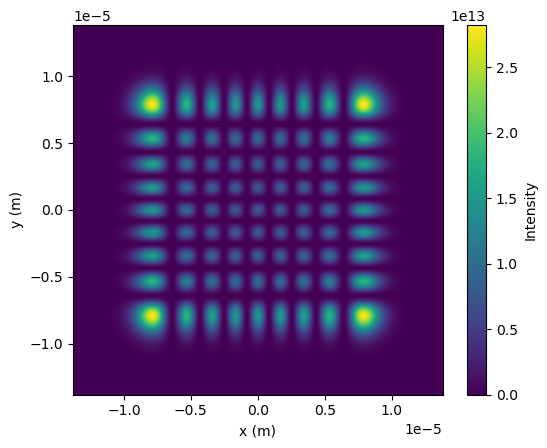

In [5]:
# Define the parameters
mode = 'hermite_gauss'
wavelength = torch.tensor(800e-9)
w0 = torch.tensor(3.45e-6) 
z = torch.tensor(1e-6)
grid_size = torch.tensor(w0*8) 
grid_dim = 201

propa = propagator(mode, wavelength, w0, grid_size, grid_dim)

N = 4
amplitude = torch.rand(N+1)
m = torch.arange(0,2*(N+1),2)
n = torch.arange(0,2*(N+1),2)


# Call the function
field = propa(z, amplitude, m, n)

# Convert the field to intensity
intensity = torch.abs(field)**2

# Plot the result
plt.imshow(intensity.cpu().numpy(), extent=[-grid_size/2, grid_size/2, -grid_size/2, grid_size/2])
plt.colorbar(label='Intensity')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

# Square-like Beams

Now the goal is to describe a flattened square laser beam using a superposition of Hermite-Gaussian (HG) modes, analogous to the description of flattened Gaussian beams with Laguerre-Gaussian modes. This involves transforming the field distribution of a square beam into a series of HG modes.

The initial field distribution for a flattened square beam at the waist plane $ z = 0 $ is proposed as a multiplication of the near-rectangular radial function that underlies the flattened Gaussian beams in both $x$ and $y$ directions:
$$ U_N(x, y, 0) = A \exp\left(-\frac{N(x^2 + y^2)}{w_0^2}\right) \sum_{m=0}^{N} \sum_{n=0}^{N} \frac{1}{m!n!} \left(\frac{Nx^2}{w_0^2}\right)^m \left(\frac{Ny^2}{w_0^2}\right)^n,$$
where $ A $ is a normalization constant, $ N $ is the order, and $ w_0 $ is the beam waist size. 

4417.8625456341715


3451.4560886024724
3131.8767791832206
2877.705368118909
2709.2217005482016
2671.057745445991


(-0.1, 1.1)

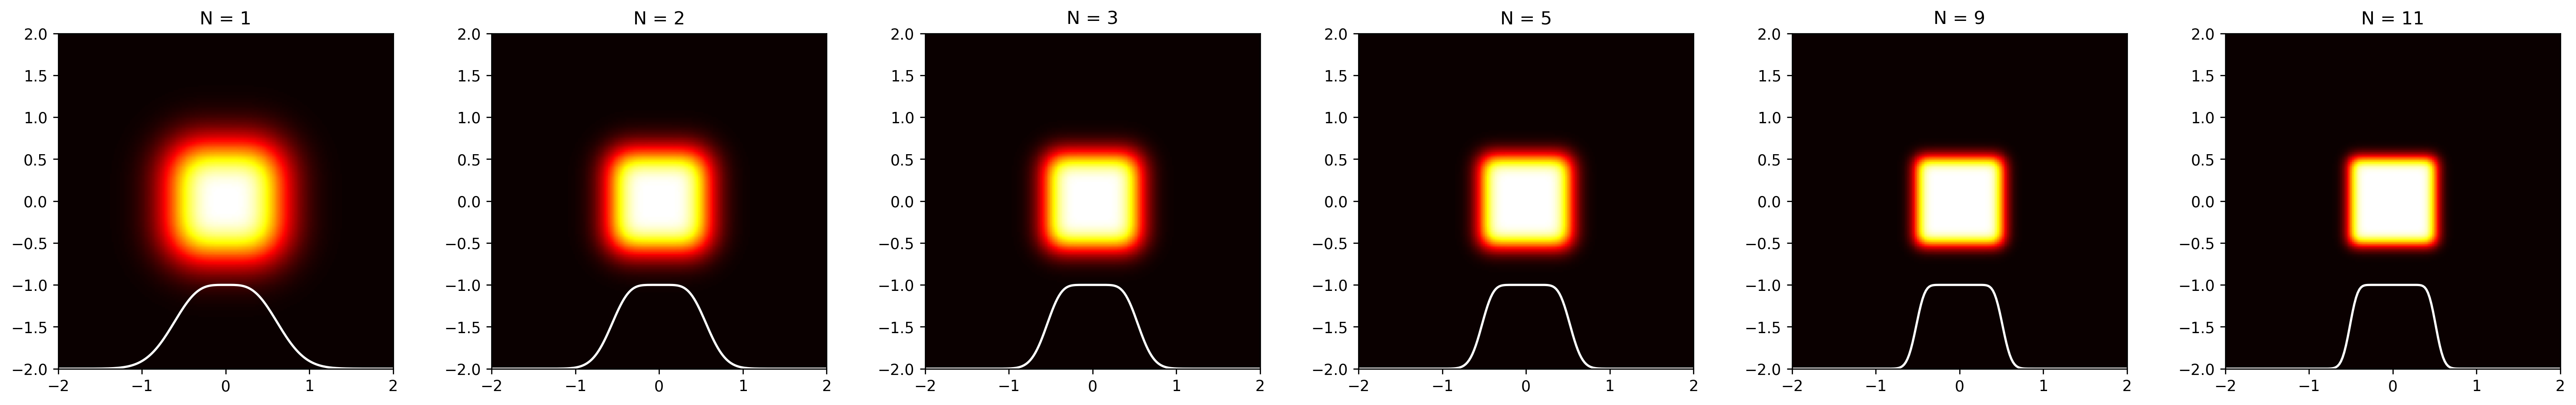

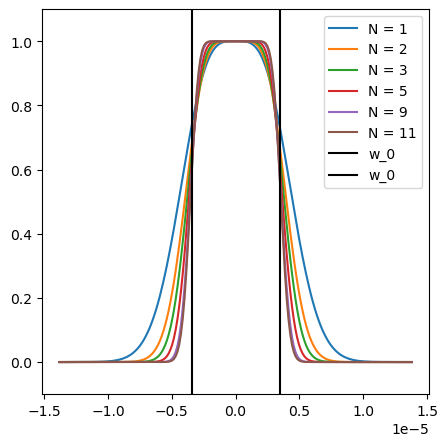

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def U_N(x, y, N, w_0, A, factorials):
    exp_term = A * np.exp(-N * (x**2 + y**2) / w_0**2)
    double_sum = np.sum([1 / (factorials[m] * factorials[n]) * (N*x**2 / w_0**2)**m * (N*y**2 / w_0**2)**n for m in range(N+1) for n in range(N+1)])
    return exp_term * double_sum

U_func = np.vectorize(U_N, excluded=['factorials'])


# Define the parameters
w_0 = propa.w0.cpu().numpy()
A = 1

# Generate the grid of x and y values
x = propa.x.cpu().numpy()
y = propa.y.cpu().numpy()
xx, yy = np.meshgrid(x, y)

fig,ax = plt.subplots(1,6,figsize=(30,4),dpi=250)
fig2, ax2 = plt.subplots(1, 1, figsize=(5, 5))
# Calculate U_N for each point on the grid and plot the result for each N
for i,N in enumerate([1,2,3,5,9,11]):
    # Pre-calculate the factorials
    factorials = [factorial(n) for n in range(N+1)]
    
    U = U_func(xx, yy, N, w_0, A, factorials=factorials)

    ax[i].imshow(U, cmap='hot', extent=(-2, 2, -2, 2))
    print(np.sum(U))
    ax[i].plot(np.linspace(-2,2,propa.grid_dim),U[100, :]-2, color='w')
    ax2.plot(x,U[100, :], label=f'N = {N}')
    ax[i].set_title(f'N = {N}')

ax2.plot(np.ones(10) * w_0, np.linspace(-1,2,10), color='k',label='w_0')
ax2.plot(-np.ones(10) * w_0, np.linspace(-1,2,10), color='k',label='w_0')
ax2.legend()
ax2.set_ylim(-.1,1.1)

# Hermite Gaussian
### We wish to have this flat beam as our initial beam (z=0). Represent as a superposition of HG modes. A single 2D HG mode is given by 
$$
E_{mn}(x, y, z) = E_0 \frac{w_0}{w(z)} H_m\left(\frac{\sqrt{2}x}{w(z)}\right) H_n\left(\frac{\sqrt{2}y}{w(z)}\right) \exp\left(-\frac{x^2 + y^2}{w(z)^2}\right) \exp\left(-i \frac{k(x^2 + y^2)z}{2(z^2 + z_R^2)}\right) \exp(-i(2m + 2n + 1)\tan^{-1}\left(\frac{z}{z_R}\right))
$$

### at z = 0, we have  

$$
E_{mn}(x, y, z=0) = E_0  H_m\left(\frac{\sqrt{2}x}{w_0}\right) H_n\left(\frac{\sqrt{2}y}{w_0}\right) \exp\left(-\frac{x^2 + y^2}{w_0^2}\right)
$$

### So represent the flat beam as:
$$
E(x,y,z=0) = \sum_{m=0}^{N} \sum_{n=0}^{N} c_{m} c_{n} E_{mn}(x, y, z=0)
$$

### lets find the coefficients $c_{m}$ and $c_{n}$

### Translation to Hermite Polynomials


From the appendix, we take the definition of Hermite inversion theorem, for Physicist Hermites:
\begin{equation}
    \chi^{2m} =  \frac{(2m)!}{2^{2m}} \sum_{k=0}^{m} \frac{1}{(2k)!(m-k)!} H_{2k}(\chi) 
\end{equation}

We can play a trick here, by setting $\chi = 2^{m} \left(\frac{\sqrt{N}x}{w_0} \right)^{2m} = \left(\frac{\sqrt{2N}x}{w_0} \right)^{2m}$. This allows us to find a formula that is suitable for the Hermite-Gauss formula (that requires the $\sqrt{2}$ in the argument of the Hermite functions but \textbf{not} in the $\exp$).

\begin{align*}
    2^{m}\left(\frac{\sqrt{N}x}{w_0} \right)^{2m} = \left(\frac{\sqrt{2N}x}{w_0} \right)^{2m} &= \frac{(2m)!}{2^{2m}} \sum_{k=0}^{m} \frac{1}{(2k)!(m-k)!} H_{2k}\left(\frac{\sqrt{2N}x}{w_0} \right)\\
    \left(\frac{\sqrt{N}x}{w_0} \right)^{2m}&=\frac{(2m)!}{2^{3m}} \sum_{k=0}^{m} \frac{1}{(2k)!(m-k)!} H_{2k}\left(\frac{\sqrt{2N}x}{w_0} \right)\\
\end{align*}


Infact, this latter formula is the same as the one quoted in ``\emph{Beam propagation factor and the kurtosis parameter
of flattened Gaussian beams}". We can then plug these into the equation and arrive at the long expression:

\begin{align*}
U_N(x, y, 0) = & A \exp\left(-\frac{N(x^2 + y^2)}{w_0^2}\right)\times \sum_{m=0}^{N} \sum_{n=0}^{N}\\
& \times  \frac{(2m)!}{m!2^{3m}} \sum_{k=0}^{m} \frac{1}{ (2k)!(m - k)!} H_{2k}\left(\frac{\sqrt{2N}x}{w_0} \right)\\
& \times  \frac{(2n)!}{n!2^{3n}} \sum_{l=0}^{n}\frac{1}{ (2l)!(n - l)!} H_{2l}\left(\frac{\sqrt{2N}y}{w_0} \right)
\end{align*}


Each mode has thus an amplitude given by,

\begin{align*}
C_{p} &= \sum_{m=p}^{N}\frac{(2m)!}{m!2^{3m}} \frac{1}{ (2p)!(m - p)!}
\end{align*}

### Quick numerical test

We can check this formula is correct by implementing this numerically.

True


(-0.1, 1.1)

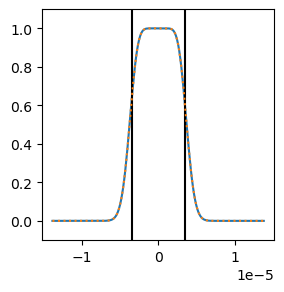

In [7]:
from scipy.special import hermite, factorial

def U_N_1D(x, N, w_0, A):
    exp_term = A * np.exp(-N * (x**2) / w_0**2)
    double_sum = np.sum([(1 / (factorial(m))) * ((N*x**2 / w_0**2)**m) for m in range(N+1) ], axis=0)
    return exp_term * double_sum 


def c_p(p, N):
    Cp = torch.tensor(0.0, dtype=torch.float64)
    for m in range(p, N+1):
        Cp += factorial(2*m) / (2**(3*m) * factorial(m) * factorial(m - p) * factorial(2*p))
    return Cp


def U_N_1D_hermite_torch(x, N, w_0, A):
    exp_term = A * torch.exp(-N * (x**2) / w_0**2)
    chi = ((2*N)**.5*x / w_0)
    first_sum = 0
    for k in range(N+1):
        first_sum += c_p(k, N) * torch.special.hermite_polynomial_h(chi, torch.tensor(2*k))
        # print(c_p(k, N))
    # print((exp_term).mean())
    
    return exp_term * first_sum


x = propa.x.cpu()
# Define the parameters
A = 1
N = 4

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# Calculate U_N for each point on the grid and plot the result for each N

# factorials = [np.math.factorial(n) for n in range(N+1)]
    
U = U_N_1D(x, N, w_0, A)
U_hermite_torch = U_N_1D_hermite_torch(x, N, w_0, A)

# check whether the two are the same using the function numpy allclose
print(np.allclose(U,U_hermite_torch))

# also print the results
ax.plot(x,U)
ax.plot(w0*np.ones(10),np.linspace(-1,2,10), color='k',label='w_0')
ax.plot(-w0*np.ones(10),np.linspace(-1,2,10), color='k',label='w_0')
ax.plot(x,U_hermite_torch, ':');
ax.set_ylim(-.1,1.1)


tensor(1., dtype=torch.float64) tensor(2795.6792, dtype=torch.float64)
tensor(1.0000, dtype=torch.float64) tensor(2401.6309, dtype=torch.float64)
tensor(1.0000, dtype=torch.float64) tensor(2299.9494, dtype=torch.float64)
tensor(1.0000, dtype=torch.float64) tensor(2247.3159, dtype=torch.float64)
tensor(1.0000, dtype=torch.float64) tensor(2244.7681, dtype=torch.float64)
tensor(1.0000, dtype=torch.float64) tensor(2251.7233, dtype=torch.float64)


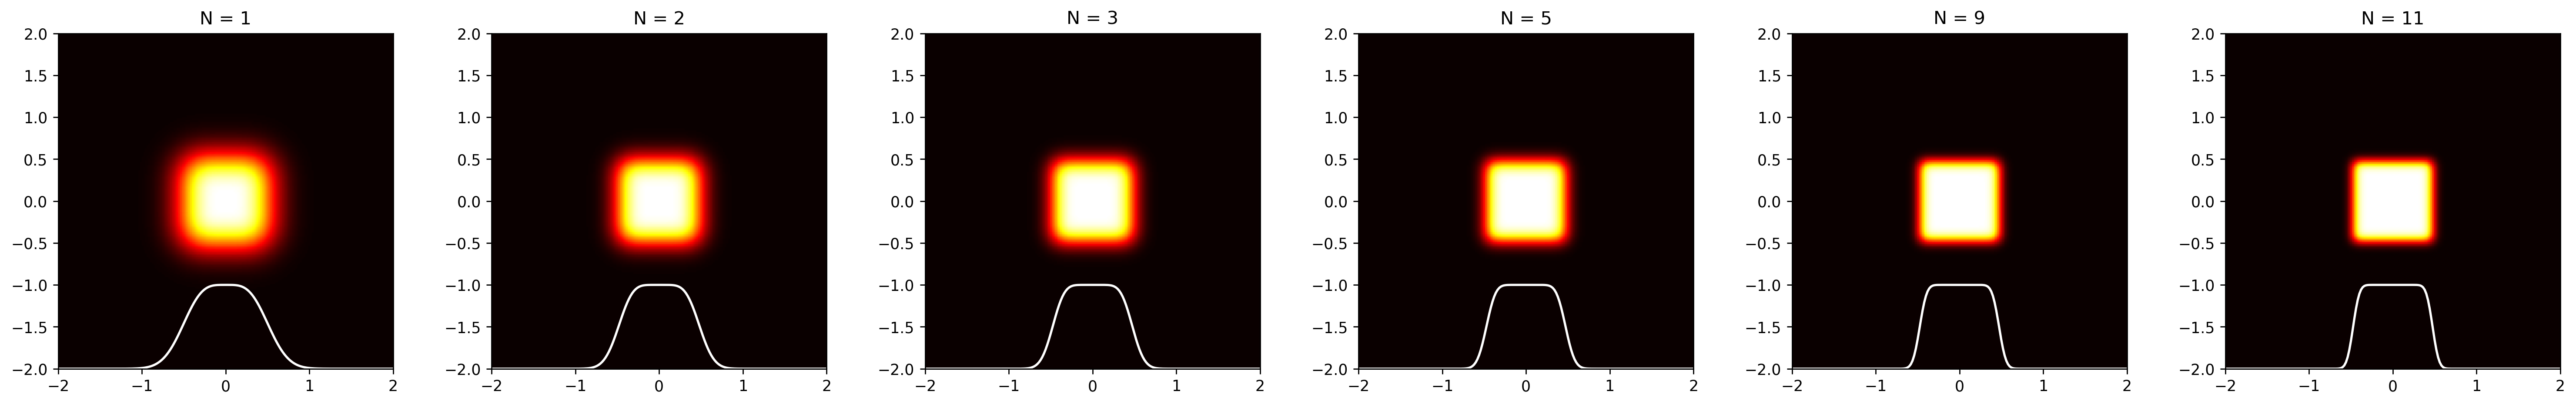

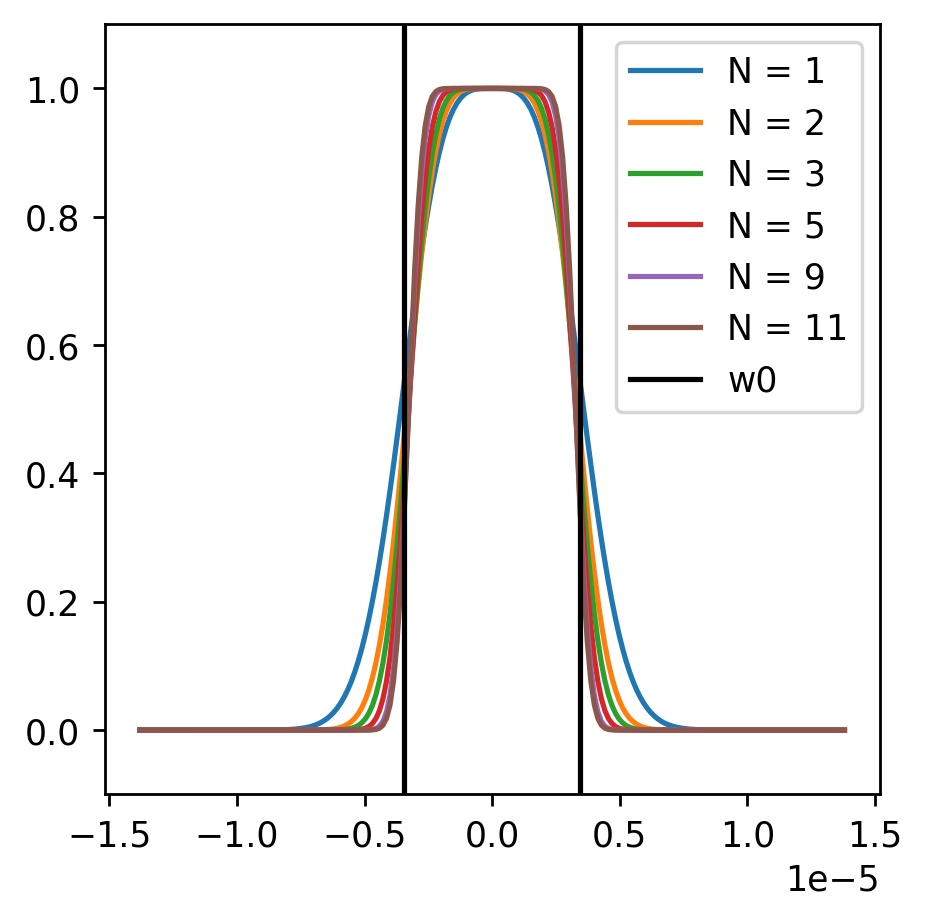

In [8]:
def make_square(N, propa):
    z = torch.tensor(0)
    
    amplitude = torch.stack([c_p(p,N)*c_p(q,N) for p in range(N+1) for q in range(N+1)])


    m = torch.arange(0,2*(N+1),2)
    n = torch.arange(0,2*(N+1),2)
    m,n = torch.meshgrid(m,n)
    m = m.flatten()
    n = n.flatten()

    field = propa(z, amplitude, m, n)
    intensity = torch.abs(field)**2

    return intensity

propa = propagator(mode, wavelength, w0, grid_size, grid_dim=201)



fig,ax = plt.subplots(1,6,figsize=(30,4),dpi=250)
fig2,ax2 = plt.subplots(1,1,figsize=(4,4),dpi=250)

for i,N in enumerate([1,2,3,5,9,11]):
    U_new = make_square(N,propa).cpu()
    print(torch.max(U_new), torch.sum(U_new))
    ax[i].imshow(U_new,cmap='hot',extent=(-2,2,-2,2))
    ax[i].plot(np.linspace(-2,2,propa.grid_dim),U_new[:, 100]-2, color='w')
    ax2.plot(propa.x,U_new[:, 100], label=f'N = {N}')

    ax[i].set_title(f'N = {N}')

ax2.plot(np.ones(10) * propa.w0.cpu().numpy(), np.linspace(-1,2,10), color='k', label='w0')
ax2.plot(-np.ones(10) * propa.w0.cpu().numpy(), np.linspace(-1,2,10), color='k')
# ax2.set_xlim(-2,2)
ax2.set_ylim(-.1,1.1)
ax2.legend()


# Now can we propagate this?

### The standard form of a Hermite-Gaussian mode is..

$$
E_{mn}(x, y, z) = E_0 \frac{w_0}{w(z)} H_m\left(\frac{\sqrt{2}x}{w(z)}\right) H_n\left(\frac{\sqrt{2}y}{w(z)}\right) \exp\left(-\frac{x^2 + y^2}{w(z)^2}\right) \exp\left(-i \frac{k(x^2 + y^2)z}{2(z^2 + z_R^2)}\right) \exp(-i(2m + 2n + 1)\tan^{-1}\left(\frac{z}{z_R}\right))
$$

Where $w(z) = w_0 \sqrt{1 + (z/z_R)^2}$.


### In our case, our initial beam $(z==0)$ is a superposition of modes. Each of these modes propagates independently.  

\begin{align*}
E_0(x, y, z==0) =  \sum_{m=0}^{N} \sum_{n=0}^{N} C_m C_n E_{2m,2n}(x,y,z=0)
\end{align*}



tensor(1.0000, dtype=torch.float64) tensor(2240.7358, dtype=torch.float64)
tensor(1.0000, dtype=torch.float64) tensor(2240.7373, dtype=torch.float64)
tensor(1.0016, dtype=torch.float64) tensor(2240.7366, dtype=torch.float64)
tensor(1.0235, dtype=torch.float64) tensor(2240.7357, dtype=torch.float64)
tensor(1.1319, dtype=torch.float64) tensor(2240.7363, dtype=torch.float64)
tensor(1.3650, dtype=torch.float64) tensor(2240.7352, dtype=torch.float64)
tensor(2.3768, dtype=torch.float64) tensor(2240.6576, dtype=torch.float64)
tensor(0.9833, dtype=torch.float64) tensor(2217.2197, dtype=torch.float64)
tensor(0.2055, dtype=torch.float64) tensor(2070.6577, dtype=torch.float64)


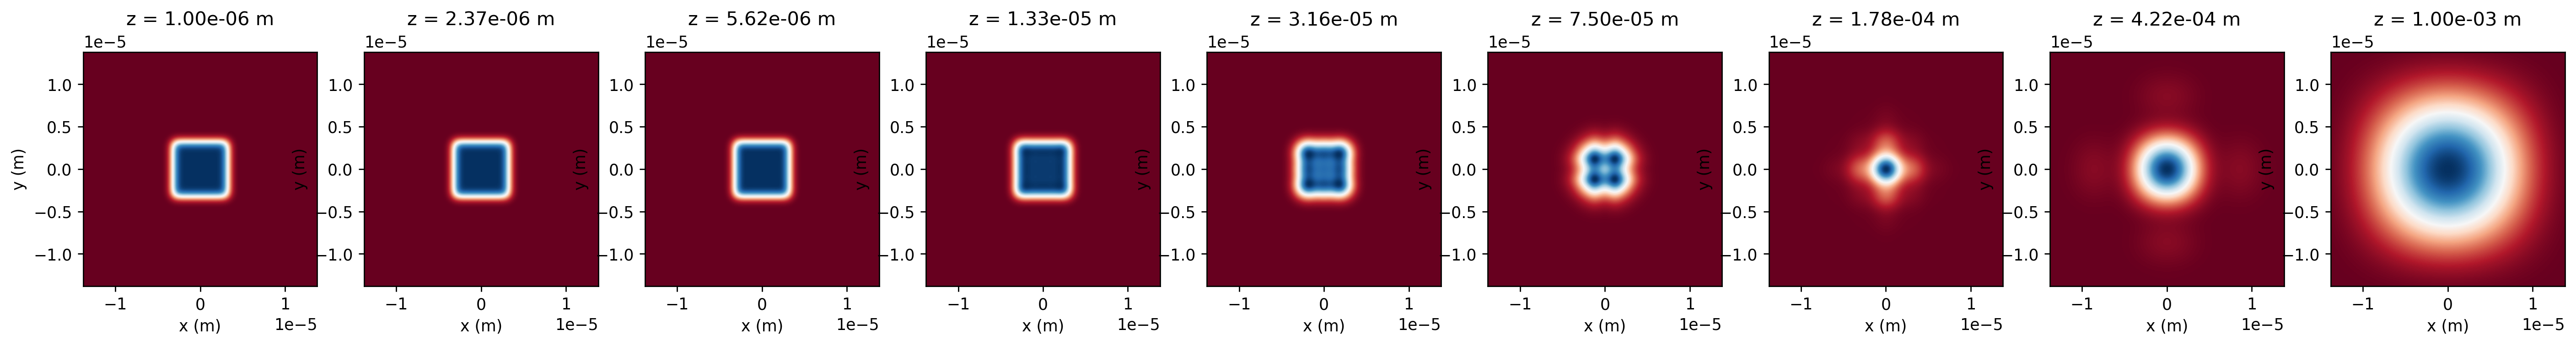

In [9]:
N=7

amplitude = torch.stack([c_p(p,N)*c_p(q,N) for p in range(N+1) for q in range(N+1)])

m = torch.arange(0,2*(N+1),2)
n = torch.arange(0,2*(N+1),2)
m,n = torch.meshgrid(m,n)
m = m.flatten()
n = n.flatten()


propa = propagator(mode, wavelength, w0, grid_size, grid_dim=201)


fig,ax = plt.subplots(1,9,figsize=(28,4),dpi=250)

for i, z in enumerate(torch.logspace(-6,-3,9)):
    field = propa(z,  amplitude, m, n)
    intensity = torch.abs(field)**2
    print(torch.max(intensity), torch.sum(intensity))


    ax[i].imshow(intensity.cpu().numpy(), extent=[-grid_size/2, grid_size/2, -grid_size/2, grid_size/2],cmap='RdBu')
    ax[i].set_title(f'z = {z:.2e} m')
    ax[i].set_xlabel('x (m)')
    ax[i].set_ylabel('y (m)')



Text(0, 0.5, 'y (m)')

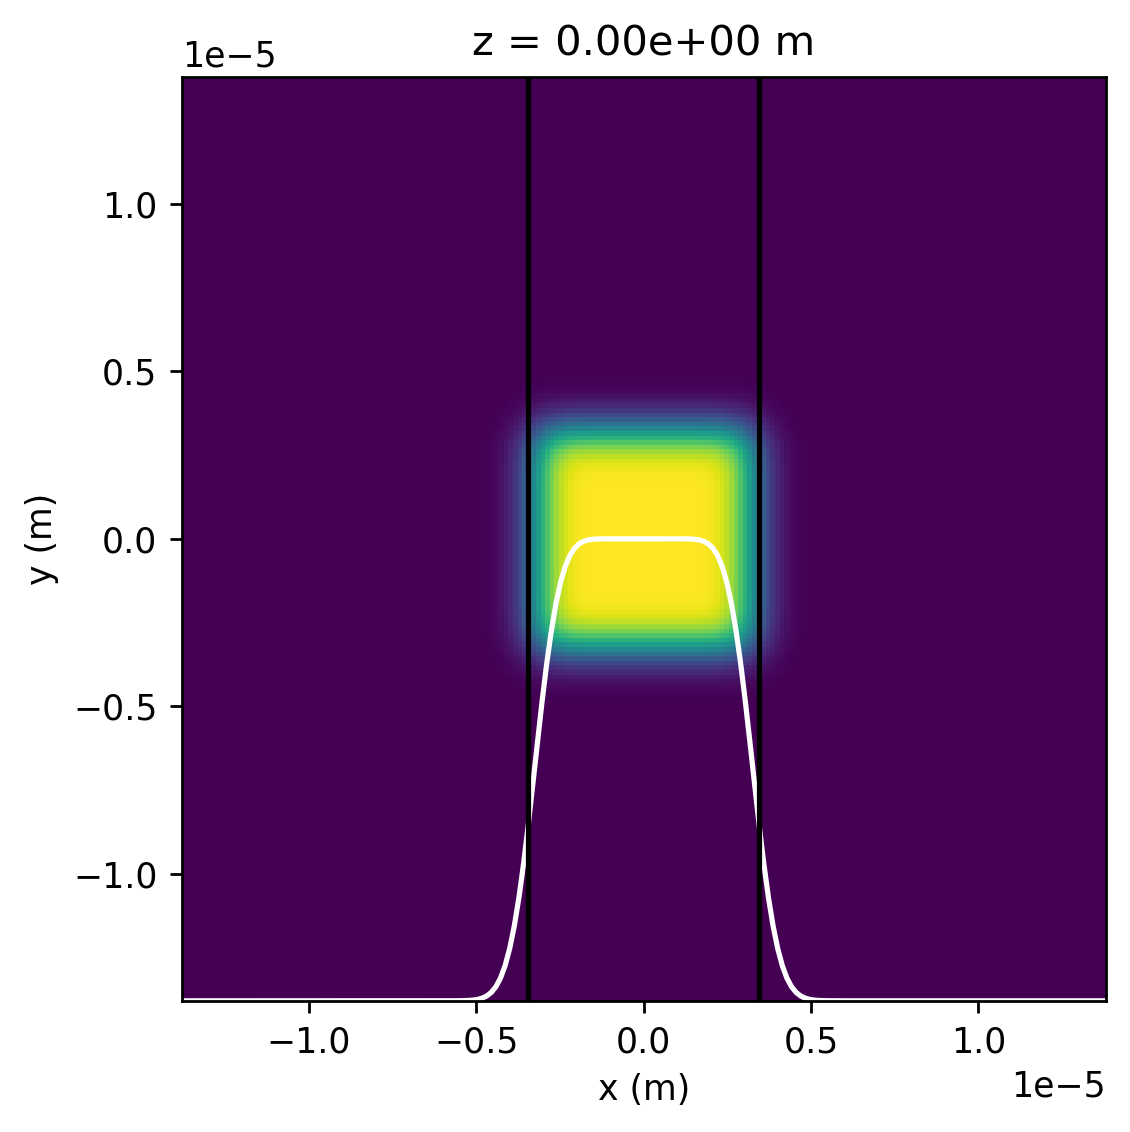

In [10]:
z=torch.tensor(0e-6)

N=5

amplitude = torch.stack([c_p(p,N)*c_p(q,N) for p in range(N+1) for q in range(N+1)])

m = torch.arange(0,2*(N+1),2)
n = torch.arange(0,2*(N+1),2)
m,n = torch.meshgrid(m,n)
m = m.flatten()
n = n.flatten()

propa = propagator(mode, wavelength, w0, grid_size, grid_dim=201)


field = propa(z,  amplitude, m, n)
intensity = torch.abs(field)**2


plt.figure(dpi=250)
plt.imshow(intensity.cpu().numpy(), extent=[-grid_size/2, grid_size/2, -grid_size/2, grid_size/2])
plt.plot(np.linspace(-grid_size/2, grid_size/2,propa.grid_dim),(intensity.cpu()[100,:] - 1) * grid_size/2 ,'w')
plt.plot(np.ones(10) * propa.w0.cpu().numpy(), torch.linspace(-1,1,10) *grid_size/2, color='k', label='w0')
plt.plot(-np.ones(10) * propa.w0.cpu().numpy(), torch.linspace(-1,1,10) *grid_size/2, color='k')
plt.title(f'z = {z:.2e} m')
plt.xlabel('x (m)')
plt.ylabel('y (m)')


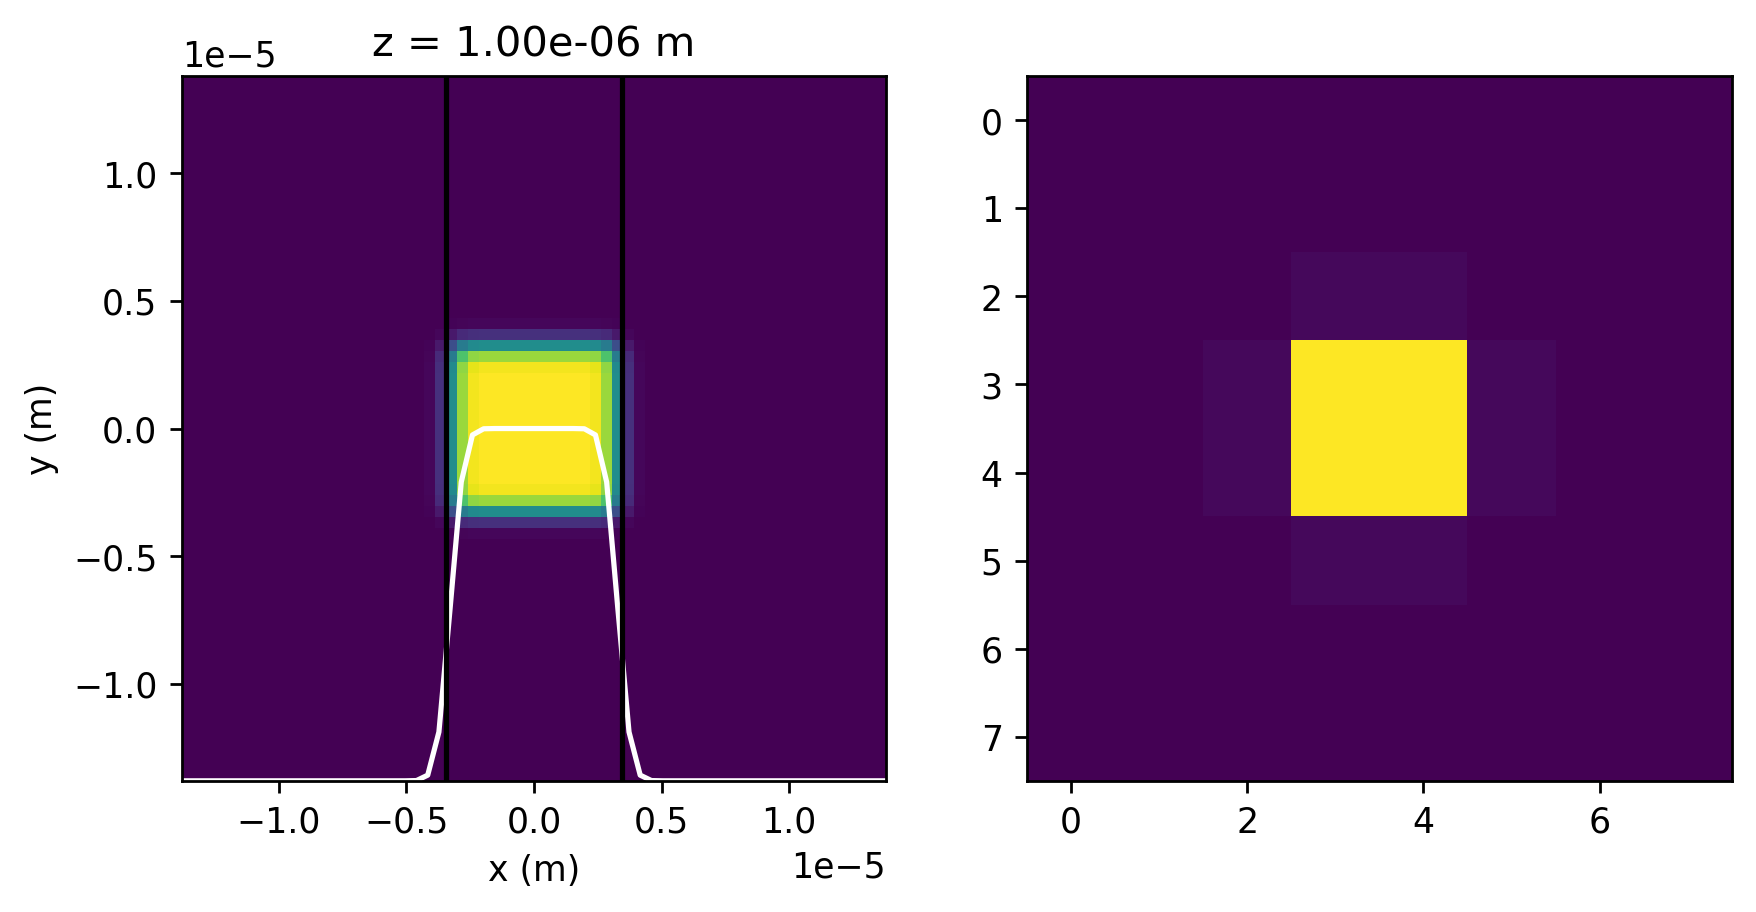

In [11]:
z=torch.tensor(1e-6)

N=11

amplitude = torch.stack([c_p(p,N)*c_p(q,N) for p in range(N+1) for q in range(N+1)])

m = torch.arange(0,2*(N+1),2)
n = torch.arange(0,2*(N+1),2)
m,n = torch.meshgrid(m,n)
m = m.flatten()
n = n.flatten()

grid_size = torch.tensor(w_0 * 8)
grid_dim = 64

propa = propagator(mode, wavelength, w0, grid_size, grid_dim)


field = propa(z,  amplitude, m, n)
intensity = torch.abs(field)**2


fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=250)
# plt.figure(dpi=250)
ax[0].imshow(intensity.cpu().numpy(), extent=[-grid_size/2, grid_size/2, -grid_size/2, grid_size/2])
ax[0].plot(np.linspace(-grid_size/2, grid_size/2,propa.grid_dim),(intensity.cpu()[propa.grid_dim//2,:] - 1) * grid_size/2 ,'w')
ax[0].plot(np.ones(10) * propa.w0.cpu().numpy(), torch.linspace(-1,1,10) *grid_size/2, color='k', label='w0')
ax[0].plot(-np.ones(10) * propa.w0.cpu().numpy(), torch.linspace(-1,1,10) *grid_size/2, color='k')
ax[0].set_title(f'z = {z:.2e} m')
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')

ax[1].imshow(nn.functional.avg_pool2d(intensity.unsqueeze(0), 8, stride=8).cpu()[0])

##  As we have many spots in our model, i want to make a propagator that can do many spots at once.

In [12]:
class multi_z_propagator(nn.Module):
    '''
    z is a 2d array.
    '''

    def __init__(self, mode, wavelength, w0, grid_size, grid_dim):
        super(multi_z_propagator, self).__init__()
        self.mode = mode
        self.wavelength = wavelength.to(device)
        self.w0 = w0.to(device)
        self.grid_size = grid_size.to(device)
        self.grid_dim = grid_dim


        self.k = 2 * torch.pi / self.wavelength  # Wavenumber
        self.z_R = torch.pi * self.w0**2 / self.wavelength
        self.x = torch.linspace(-self.grid_size / 2, self.grid_size / 2, self.grid_dim)
        self.y = torch.linspace(-self.grid_size / 2, self.grid_size / 2, self.grid_dim)
        self.X, self.Y = torch.meshgrid(self.x, self.y)
        self.X = self.X.reshape(self.grid_dim,self.grid_dim,1,1).to(device)
        self.Y = self.Y.reshape(self.grid_dim,self.grid_dim,1,1).to(device)
        self.r = torch.sqrt(self.X**2 + self.Y**2)  # Radial coordinate
        self.phi = torch.atan2(self.Y, self.X)

    def forward(self, z, coefficients, m=0, n=0, l=0, p=0):

        z = z.view(1,1,z.shape[0],z.shape[1])
        
        if self.mode == 'hermite_gauss':
            m = m.view(-1, 1, 1, 1, 1)
            n = n.view(-1, 1, 1, 1, 1)
            m = m.to(device)
            n = n.to(device)

        elif self.mode == 'laguerre_gauss':
            l = l.view(-1, 1, 1, 1)
            p = p.view(-1, 1, 1, 1)
            l = l.to(device)
            p = p.to(device)


        
        coefficients = coefficients.view(-1, 1, 1, 1, 1)
        coefficients = coefficients.to(device)
        N = np.sqrt(len(coefficients)) -1 #amplitude is the flattened meshed amplitude of the modes for each direction, so sqrt of that is the number of modes. take away 1 as we start from 0
        sqrt_N = torch.tensor(np.sqrt(N))

        self.v0 = self.w0 / sqrt_N 
        # Beam radius at distance z
        self.v_z = self.v0 * torch.sqrt(1 + (z / self.z_R)**2)  #important factor of sqrtN there.

        
            
        # Electric field distribution
        sqrt_2 = torch.tensor(2).sqrt()  # Convert constant to tensor
        gaussian_term = torch.exp(-(self.X**2 + self.Y**2) / self.v_z**2)
        radial_phase = -self.k * (self.X**2 + self.Y**2) * z / (2 * (z**2 + self.z_R**2))
        prop_phase = -self.k*z



        if self.mode == 'hermite_gauss':
            coefficients = coefficients * (self.v0 / self.v_z)
            hermite_x = torch.special.hermite_polynomial_h(sqrt_2 * self.X / self.v_z, m) #if torch.any(m != 0) else 1
            hermite_y = torch.special.hermite_polynomial_h(sqrt_2 * self.Y / self.v_z, n) #if torch.any(n != 0) else 1
            gouy_phase = ((m + n) + 1) * torch.atan(z / self.z_R)
            field = coefficients *  hermite_x * hermite_y * gaussian_term * torch.exp(1j * (radial_phase + gouy_phase + prop_phase))

        elif self.mode == 'laguerre_gauss':
            amplitude = amplitude * (self.v0 / self.v_z) * (self.r * sqrt_2 / self.v_z).abs()**abs(l)
            laguerre_term = torch.special.laguerre_polynomial_l(2 * self.r**2 / self.v_z**2, p) if torch.any(l != 0) or torch.any(p != 0) else 1
            azimuthal_phase = l * self.phi
            gouy_phase = -(2 * p + abs(l) + 1) * torch.atan(z / self.z_R)
            field = amplitude * laguerre_term * gaussian_term * torch.exp(1j * (radial_phase + azimuthal_phase + gouy_phase))
        else:
            raise ValueError("Invalid mode. Choose from 'hermite_gauss' or 'laguerre_gauss'.")

        # # sum the fields over the batch dimension
        field = field.sum(dim=0)
        
        return field

/tmp/user/25186/ipykernel_92757/2954263960.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_size = torch.tensor(w0*8)


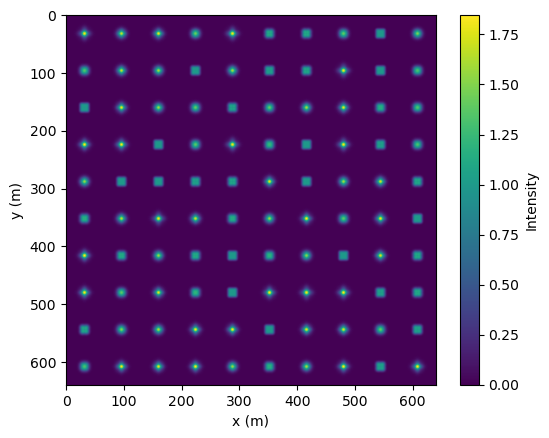

In [19]:
# Define the parameters
mode = 'hermite_gauss'
wavelength = torch.tensor(800e-9)
w0 = torch.tensor(3.45e-6) 
z = torch.rand(10,10) * 1e-4
grid_size = torch.tensor(w0*8) 
grid_dim = 64

propa = multi_z_propagator(mode, wavelength, w0, grid_size, grid_dim)

N=3

amplitude = torch.stack([c_p(p,N)*c_p(q,N) for p in range(N+1) for q in range(N+1)])

m = torch.arange(0,2*(N+1),2)
n = torch.arange(0,2*(N+1),2)
m,n = torch.meshgrid(m,n)
m = m.flatten()
n = n.flatten()


# Call the function
field = propa(z, amplitude, m, n)

# Convert the field to intensity
intensity = torch.abs(field)**2

flat_intensity = torch.zeros(10*grid_dim,10*grid_dim)

for i in range(10):
    for j in range(10):
        flat_intensity[i*grid_dim:(i+1)*grid_dim,j*grid_dim:(j+1)*grid_dim] = intensity[...,i,j].cpu()


# Plot the result
plt.imshow(flat_intensity.cpu().numpy())#, extent=[-grid_size/2, grid_size/2, -grid_size/2, grid_size/2])
plt.colorbar(label='Intensity')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()